Blast query elapsed time estmate.

In [19]:
import numpy as np
import pandas as pd
from time import time
from IPython.display import display # Allows the use of display() for DataFrames
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV, ShuffleSplit, RandomizedSearchCV
from sklearn.metrics import mean_squared_error

from sklearn.ensemble import GradientBoostingRegressor,AdaBoostRegressor,RandomForestRegressor
import xgboost

import matplotlib.pyplot as plt
plt.rcParams['figure.figsize'] = (10, 6)

%matplotlib inline

In [20]:
# Load the Census dataset
data = pd.read_csv("data/data_00_12.csv")
#data = data[data['dbid']!=0]
# Success - Display the first record
display(data.head(n=5))

,RID,f_ipv4,service_type,program,length_bp,dbid,dbsize_bp,started_at,run_time
0,TDGY46AV014,113167994,8,0,3420,0,123456,Oct 4 2019 12:00:04:750AM,2
1,TDGY62G1014,1011673673,8,0,915,0,123456,Oct 4 2019 12:00:06:800AM,2
2,TDGY7MGV014,-106884996,11,0,521,6154732,251782689291,Oct 4 2019 12:00:08:377AM,9
3,TDGY8SBB014,177491310,11,0,152,6154732,251782689291,Oct 4 2019 12:00:08:923AM,3
4,TDGY8J44014,789795757,2,2,250,93593,12472129,Oct 4 2019 12:00:08:847AM,2


In [21]:
# Drop column that should not affect runtime of a query
df = data.drop(['RID'], axis=1)
display(df.head(n=5))

,f_ipv4,service_type,program,length_bp,dbid,dbsize_bp,started_at,run_time
0,113167994,8,0,3420,0,123456,Oct 4 2019 12:00:04:750AM,2
1,1011673673,8,0,915,0,123456,Oct 4 2019 12:00:06:800AM,2
2,-106884996,11,0,521,6154732,251782689291,Oct 4 2019 12:00:08:377AM,9
3,177491310,11,0,152,6154732,251782689291,Oct 4 2019 12:00:08:923AM,3
4,789795757,2,2,250,93593,12472129,Oct 4 2019 12:00:08:847AM,2


In [22]:
categoricals100 = ("f_ipv4", "dbid")
for c in categoricals100:
    df.loc[data[c].value_counts()[df[c]].values < 100, c] = 0
    dummies = pd.get_dummies(df[c], prefix=c)
    df = pd.concat([df, dummies], axis=1)
    df.drop(c, axis=1, inplace=True)
display(df.head(n=5)) 

,service_type,program,length_bp,dbsize_bp,started_at,run_time,f_ipv4_-2009940599,f_ipv4_-2006913662,f_ipv4_-1725110381,f_ipv4_-1550285120,...,dbid_1335343,dbid_1536283,dbid_2938612,dbid_3042692,dbid_3820422,dbid_3820442,dbid_3820502,dbid_4032492,dbid_6154732,dbid_6409862
0,8,0,3420,123456,Oct 4 2019 12:00:04:750AM,2,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,8,0,915,123456,Oct 4 2019 12:00:06:800AM,2,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,11,0,521,251782689291,Oct 4 2019 12:00:08:377AM,9,0,0,0,0,...,0,0,0,0,0,0,0,0,1,0
3,11,0,152,251782689291,Oct 4 2019 12:00:08:923AM,3,0,0,0,0,...,0,0,0,0,0,0,0,0,1,0
4,2,2,250,12472129,Oct 4 2019 12:00:08:847AM,2,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [23]:
df['datetime'] = pd.to_datetime(df['started_at'], format="%b %d %Y %I:%M:%S:%f%p")
df.drop("started_at", axis=1, inplace=True)
dummies_hour = pd.get_dummies(df.datetime.dt.hour, prefix="hour")
df = pd.concat([df, dummies_hour], axis=1)
df.drop("datetime", axis=1, inplace=True)
display(df.head(n=5))

,service_type,program,length_bp,dbsize_bp,run_time,f_ipv4_-2009940599,f_ipv4_-2006913662,f_ipv4_-1725110381,f_ipv4_-1550285120,f_ipv4_-1374155134,...,hour_8,hour_9,hour_10,hour_11,hour_12,hour_13,hour_14,hour_15,hour_16,hour_17
0,8,0,3420,123456,2,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,8,0,915,123456,2,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,11,0,521,251782689291,9,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,11,0,152,251782689291,3,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,2,2,250,12472129,2,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [24]:
# Transform categorical features
categorical = ['service_type', 'program']
df = pd.get_dummies(pd.DataFrame(data = df), columns=categorical)

# Apply log scale to run time
df[['run_time']] = df[['run_time']].apply(lambda x: np.log(x))
display(df.head(n=5))

,length_bp,dbsize_bp,run_time,f_ipv4_-2009940599,f_ipv4_-2006913662,f_ipv4_-1725110381,f_ipv4_-1550285120,f_ipv4_-1374155134,f_ipv4_-1323626116,f_ipv4_-1266775282,...,service_type_11,service_type_20,service_type_21,service_type_22,service_type_88,program_0,program_1,program_2,program_3,program_4
0,3420,123456,0.693147,0,0,0,0,0,0,0,...,0,0,0,0,0,1,0,0,0,0
1,915,123456,0.693147,0,0,0,0,0,0,0,...,0,0,0,0,0,1,0,0,0,0
2,521,251782689291,2.197225,0,0,0,0,0,0,0,...,1,0,0,0,0,1,0,0,0,0
3,152,251782689291,1.098612,0,0,0,0,0,0,0,...,1,0,0,0,0,1,0,0,0,0
4,250,12472129,0.693147,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0


In [25]:
# Select target serices
run_time = df['run_time']
df = df.drop('run_time', axis = 1)

In [26]:
# Split the features and 'run_time' data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(df, 
                                                    run_time, 
                                                    test_size = 0.2, 
                                                    random_state = 12345)

# Show the results of the split
print("Training set has {} samples.".format(X_train.shape[0]))
print("Testing set has {} samples.".format(X_test.shape[0]))

Training set has 44866 samples.
Testing set has 11217 samples.


In [27]:
def r2_score(model, X, y):
    model.fit(X, y)
    return model.score(X, y)

In [28]:
def evaluate(model, X, y):
    score = cross_val_score(model, X, y, cv=10, scoring='neg_mean_squared_error')
    return score.mean()

In [29]:
# Establish a baseline
# Compute regressor MSE on train set using cross validation for different
# data set sizes: 1%, 10%, 100%
clf_A = AdaBoostRegressor(n_estimators=50, random_state=112233)
clf_B = RandomForestRegressor(n_estimators=50, random_state=112233)
clf_C = GradientBoostingRegressor(n_estimators=50, random_state=112233)

N = len(y_train)
samples_100 = N
samples_10 = int(0.1 * N + 0.5)
samples_1 = int(0.01 * N + 0.5)

size = {0: samples_1,
        1: samples_10,
        2: samples_100}

# Collect results on the learners
results = {}
for clf in [clf_A, clf_B, clf_C]:
    clf_name = clf.__class__.__name__
    results[clf_name] = {}
    for i, samples in enumerate([samples_1, samples_10, samples_100]):
        results[clf_name][i] = evaluate(clf, X_train[: samples], y_train[:samples])
        
for name, values in results.items():
    print("{}".format(name))
    for k, error in values.items():
        print("\tsamples={}\t\tMSE={}".format(size[k], error*-1))

AdaBoostRegressor
	samples=449		MSE=1.974462861173914
	samples=4487		MSE=1.637756363538004
	samples=44866		MSE=1.8682938510519158
RandomForestRegressor
	samples=449		MSE=1.4705704231560044
	samples=4487		MSE=0.9917429712025972
	samples=44866		MSE=0.8423733411095066
GradientBoostingRegressor
	samples=449		MSE=1.4759601335880486
	samples=4487		MSE=1.1043268034722755
	samples=44866		MSE=1.0431872665350244


In [30]:
def search(model, param_grid, X, y):
    model = RandomizedSearchCV(estimator = model, 
                               n_iter=20, 
                               param_distributions = param_grid, 
                               scoring='r2', #'neg_mean_squared_error',
                               n_jobs=4,
                               iid=False, 
                               cv=5)
    model.fit(X, y)
    return model

In [31]:
# Pick learning rate
for lr in [0.1, 0.05, 0.02, 0.01]:
    model = GradientBoostingRegressor(learning_rate=lr)
    score = r2_score(model, X_train, y_train)
    print("lr={}\tscore={}".format(lr, score))

lr=0.1	score=0.6733452387591331
lr=0.05	score=0.6431469931553115
lr=0.02	score=0.5747475362432244
lr=0.01	score=0.4588045933206434


In [32]:
learn_rate = 0.1
for i in [100, 200, 300, 500, 700, 1000]:
    model = GradientBoostingRegressor(learning_rate=learn_rate, n_estimators=i)
    score = r2_score(model, X_train, y_train)
    print("estimators={}\tscore={}".format(i, score))

estimators=100	score=0.6733452387591331
estimators=200	score=0.6991971995488175
estimators=300	score=0.7110965948724481
estimators=500	score=0.7242796223289529
estimators=700	score=0.7326390160468312
estimators=1000	score=0.7432042305786105


In [33]:
# Pick max_depth and min_samples_split
param_test = {'max_depth':[x for x in range(3,21,2)], 'min_samples_split':[x for x in range(5,80,10)]}
model = search(GradientBoostingRegressor(learning_rate=0.1, 
                                         n_estimators=200, 
                                         subsample=0.8, 
                                         random_state=10),
                                         param_test, 
                                         X_train, 
                                         y_train)
print(model.best_estimator_)
print(model.best_params_)

GradientBoostingRegressor(alpha=0.9, criterion='friedman_mse', init=None,
             learning_rate=0.1, loss='ls', max_depth=11, max_features=None,
             max_leaf_nodes=None, min_impurity_decrease=0.0,
             min_impurity_split=None, min_samples_leaf=1,
             min_samples_split=65, min_weight_fraction_leaf=0.0,
             n_estimators=200, n_iter_no_change=None, presort='auto',
             random_state=10, subsample=0.8, tol=0.0001,
             validation_fraction=0.1, verbose=0, warm_start=False)
{'min_samples_split': 65, 'max_depth': 11}


In [34]:
# Evaluate model performance
max_depth=model.best_params_['max_depth']
min_samples_split = model.best_params_['min_samples_split']
model = GradientBoostingRegressor(learning_rate=0.1, 
                                         max_depth=max_depth,
                                         min_samples_split = min_samples_split,
                                         n_estimators=200, 
                                         subsample=0.8, 
                                         random_state=10)
model.fit(X_train, y_train)
score = model.score(X_train, y_train)
print("Train data set score...{}".format(score))

Train data set score...0.8090722052845656


In [35]:
# Pick min_samples_leaf
param_test = {'min_samples_leaf': [x for x in range(3, 15, 2)]}
model = search(GradientBoostingRegressor(learning_rate=0.1, 
                                         max_depth=max_depth,
                                         min_samples_split=min_samples_split,
                                         n_estimators=200, 
                                         subsample=0.8, 
                                         random_state=10),
                                         param_test, 
                                         X_train, 
                                         y_train)
print(model.best_estimator_)
print(model.best_params_)

/home/akotliarov/anaconda3/envs/env3/lib/python3.7/site-packages/sklearn/model_selection/_search.py:271: UserWarning: The total space of parameters 6 is smaller than n_iter=20. Running 6 iterations. For exhaustive searches, use GridSearchCV.
  % (grid_size, self.n_iter, grid_size), UserWarning)


GradientBoostingRegressor(alpha=0.9, criterion='friedman_mse', init=None,
             learning_rate=0.1, loss='ls', max_depth=11, max_features=None,
             max_leaf_nodes=None, min_impurity_decrease=0.0,
             min_impurity_split=None, min_samples_leaf=3,
             min_samples_split=65, min_weight_fraction_leaf=0.0,
             n_estimators=200, n_iter_no_change=None, presort='auto',
             random_state=10, subsample=0.8, tol=0.0001,
             validation_fraction=0.1, verbose=0, warm_start=False)
{'min_samples_leaf': 3}


In [36]:
# Evaluate model performance
min_samples_leaf = model.best_params_['min_samples_leaf']
model = GradientBoostingRegressor(learning_rate=0.1, 
                                         max_depth=max_depth,
                                         min_samples_split = min_samples_split,
                                         min_samples_leaf = min_samples_leaf,
                                         n_estimators=200, 
                                         subsample=0.8, 
                                         random_state=10)
model.fit(X_train, y_train)
score = model.score(X_train, y_train)
print("Train data set score...{}".format(score))

Train data set score...0.8030781187937869


In [52]:
# Final model.
model = GradientBoostingRegressor(learning_rate=0.1, 
                                         max_depth=max_depth,
                                         min_samples_split = min_samples_split,
                                         min_samples_leaf = min_samples_leaf,
                                         n_estimators=400, 
                                         subsample=0.7, 
                                         random_state=10)
model.fit(X_train, y_train)
score = model.score(X_train, y_train)
print("Train data set score...{}".format(score))

Train data set score...0.8203934792293619


In [53]:
# Model's performance on test data.
score = model.score(X_test, y_test)
print("Test data set score...{}".format(score))
mse = mean_squared_error(y_test, model.predict(X_test))
print("MSE: %.4f" % mse)

Test data set score...0.7392913384375952
MSE: 0.7475


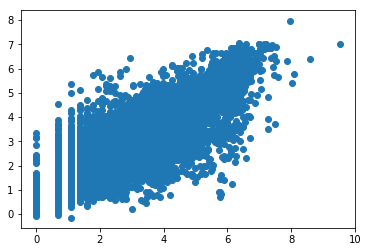

In [54]:
prediction = model.predict(X_test)
plt.scatter(y_test, prediction)

In [55]:
model = xgboost.XGBRegressor(objective="reg:squarederror", 
                             subsample=0.7,
                             learning_rate=0.1,
                             min_samples_leaf = min_samples_leaf,
                             min_samples_split=min_samples_split,
                             max_depth=max_depth, 
                             n_estimators=400)
model.fit(X_train, y_train)
score = model.score(X_train, y_train)
print("Train data set score...R2={}, MSE={}".format(score, mean_squared_error(y_train, model.predict(X_train))))
score = model.score(X_test, y_test)
print("Test data set score...R2={}, MSE={}".format(score, mean_squared_error(y_test, model.predict(X_test))))


/home/akotliarov/anaconda3/envs/env3/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


Train data set score...R2=0.8801657337532894, MSE=0.3485745227336909
Test data set score...R2=0.7295618365563339, MSE=0.7753913765150747


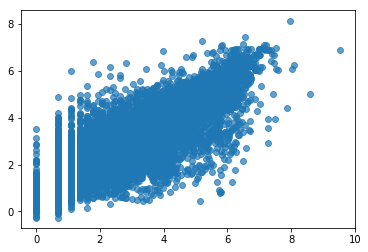

In [56]:
prediction = model.predict(X_test)
plt.scatter(y_test, prediction, alpha=0.7)